# Lab 6: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [14]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [15]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

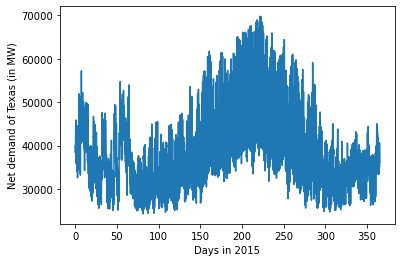

In [16]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (10 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**One can infer that the weather of Texas is most extreme (hot or cold) towards the middle of the year, with a a similar issue but less extreme at the beginning of the year as well. This is because extreme weather usually requires either more heating or cooling. This is verified by observing that the beginning of the year is a reasonably cold time (needs heating), while the middle needs lots of cooling due to extremely hot weather.
In Illinois, we would expect a larger spike at the beginning and end of the year due to much more extreme cold weather (needs heating). By contrast, we'd expect a smaller spike towards the middle of the year as summers are not as hot in Illinois as in Texas.**


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


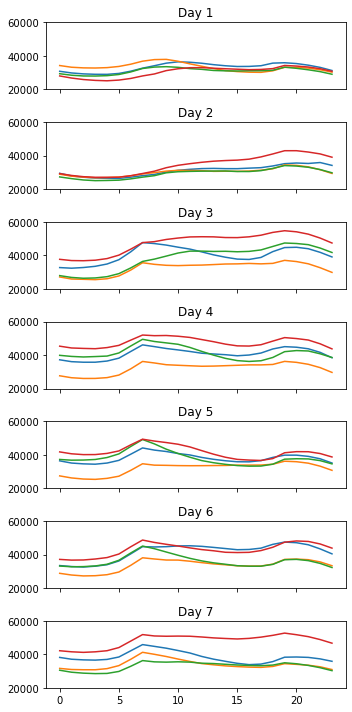

In [17]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (15 points).** Can you find any discernible change in the load profiles of different days of the week? Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? 


**In August, it seems that there is less discernible change on the load profiles due to the days of the week (as compared to the previous output), meaning that the profiles look quite similar over all days of the week. 
In terms of differences between August and January, due to the higher temperatures in Texas, there is significantly higher power usage in August used as cooling, with it being lower earlier in the day (cooler temperatures) and higher later in the afternoon and late evening as it's warmer outside.**

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


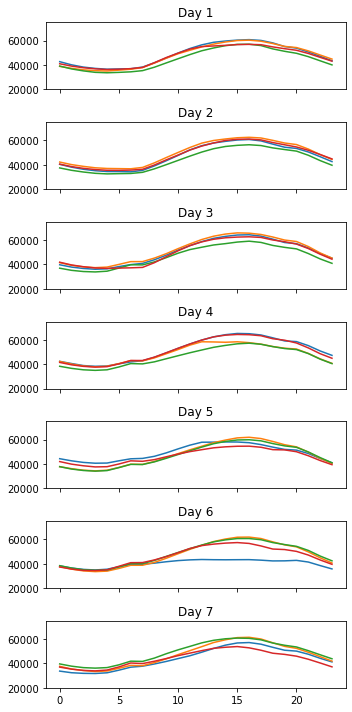

In [18]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 226
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [19]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [20]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

**Question (25 points). Insert code to design the NN and its optimizer (use the relu function)** 

In [23]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.layers.Input(nDimX) #insert code
nn_layer = keras.layers.Dense(nHidden, activation="relu")(inputs) #insert code
outputs = keras.layers.Dense(nDimY, activation="relu")(nn_layer)#insert code

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model.compile(
    optimizer= tf.optimizers.Adagrad(learning_rate=0.5),#insert code
    loss= keras.losses.MeanSquaredError()#insert code 
)



### Train the neural network via Keras.

Create the training module for the NN. 

Keras is a user-friendly framework to define, train and test neural networks. Check their page out for more details. https://keras.io/ 

Feed the training data in batches of size 'batchSize'.Usually, going through the training data once does not train your NN. You train over the same data multiple times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn a material by reading through it once!

**Question (20 points). Insert code to define the training module**

In [24]:
batchSize = 60 #
nEpochs = 1000 #

# Train the model

print("Fit model on training data")

history = model.fit(
    # insert code
    trainX,
    trainY,
    batch_size=batchSize,
    epochs=nEpochs
)


Fit model on training data
Epoch 1/1000
5/5 [==============================] - 0s 2ms/step - loss: 1317890176.0000
Epoch 2/1000
5/5 [==============================] - 0s 2ms/step - loss: 460212416.0000
Epoch 3/1000
5/5 [==============================] - 0s 2ms/step - loss: 332641760.0000
Epoch 4/1000
5/5 [==============================] - 0s 2ms/step - loss: 322336640.0000
Epoch 5/1000
5/5 [==============================] - 0s 2ms/step - loss: 317193600.0000
Epoch 6/1000
5/5 [==============================] - 0s 2ms/step - loss: 316438336.0000
Epoch 7/1000
5/5 [==============================] - 0s 2ms/step - loss: 312209664.0000
Epoch 8/1000
5/5 [==============================] - 0s 2ms/step - loss: 306884128.0000
Epoch 9/1000
5/5 [==============================] - 0s 2ms/step - loss: 304713728.0000
Epoch 10/1000
5/5 [==============================] - 0s 2ms/step - loss: 301292128.0000
Epoch 11/1000
5/5 [==============================] - 0s 2ms/step - loss: 299052000.0000
Epoch 12/1000

5/5 [==============================] - 0s 1ms/step - loss: 47623484.0000
Epoch 95/1000
5/5 [==============================] - 0s 1ms/step - loss: 47325544.0000
Epoch 96/1000
5/5 [==============================] - 0s 1ms/step - loss: 46973832.0000
Epoch 97/1000
5/5 [==============================] - 0s 1ms/step - loss: 46554140.0000
Epoch 98/1000
5/5 [==============================] - 0s 1ms/step - loss: 46456852.0000
Epoch 99/1000
5/5 [==============================] - 0s 1ms/step - loss: 46011616.0000
Epoch 100/1000
5/5 [==============================] - 0s 1ms/step - loss: 45620608.0000
Epoch 101/1000
5/5 [==============================] - 0s 1ms/step - loss: 45577780.0000
Epoch 102/1000
5/5 [==============================] - 0s 1ms/step - loss: 44982528.0000
Epoch 103/1000
5/5 [==============================] - 0s 1ms/step - loss: 44709492.0000
Epoch 104/1000
5/5 [==============================] - 0s 1ms/step - loss: 44689968.0000
Epoch 105/1000
5/5 [==============================] 

5/5 [==============================] - 0s 1ms/step - loss: 31519078.0000
Epoch 188/1000
5/5 [==============================] - 0s 1ms/step - loss: 31301894.0000
Epoch 189/1000
5/5 [==============================] - 0s 1ms/step - loss: 31239330.0000
Epoch 190/1000
5/5 [==============================] - 0s 1ms/step - loss: 31368736.0000
Epoch 191/1000
5/5 [==============================] - 0s 1ms/step - loss: 31155758.0000
Epoch 192/1000
5/5 [==============================] - 0s 1ms/step - loss: 31049470.0000
Epoch 193/1000
5/5 [==============================] - 0s 1ms/step - loss: 30819200.0000
Epoch 194/1000
5/5 [==============================] - 0s 1ms/step - loss: 30869590.0000
Epoch 195/1000
5/5 [==============================] - 0s 1ms/step - loss: 30842532.0000
Epoch 196/1000
5/5 [==============================] - 0s 1ms/step - loss: 30650658.0000
Epoch 197/1000
5/5 [==============================] - 0s 1ms/step - loss: 30656384.0000
Epoch 198/1000
5/5 [===========================

5/5 [==============================] - 0s 1ms/step - loss: 24588184.0000
Epoch 281/1000
5/5 [==============================] - 0s 1ms/step - loss: 24733186.0000
Epoch 282/1000
5/5 [==============================] - 0s 1ms/step - loss: 24576504.0000
Epoch 283/1000
5/5 [==============================] - 0s 1ms/step - loss: 24454010.0000
Epoch 284/1000
5/5 [==============================] - 0s 1ms/step - loss: 24406604.0000
Epoch 285/1000
5/5 [==============================] - 0s 1ms/step - loss: 24358692.0000
Epoch 286/1000
5/5 [==============================] - 0s 1ms/step - loss: 24400146.0000
Epoch 287/1000
5/5 [==============================] - 0s 1ms/step - loss: 24359624.0000
Epoch 288/1000
5/5 [==============================] - 0s 1ms/step - loss: 24129060.0000
Epoch 289/1000
5/5 [==============================] - 0s 1ms/step - loss: 24041234.0000
Epoch 290/1000
5/5 [==============================] - 0s 1ms/step - loss: 24072074.0000
Epoch 291/1000
5/5 [===========================

5/5 [==============================] - 0s 1ms/step - loss: 19540540.0000
Epoch 374/1000
5/5 [==============================] - 0s 1ms/step - loss: 19507294.0000
Epoch 375/1000
5/5 [==============================] - 0s 1ms/step - loss: 19430060.0000
Epoch 376/1000
5/5 [==============================] - 0s 1ms/step - loss: 19421722.0000
Epoch 377/1000
5/5 [==============================] - 0s 1ms/step - loss: 19563136.0000
Epoch 378/1000
5/5 [==============================] - 0s 1ms/step - loss: 19441636.0000
Epoch 379/1000
5/5 [==============================] - 0s 1ms/step - loss: 19344406.0000
Epoch 380/1000
5/5 [==============================] - 0s 1ms/step - loss: 19287530.0000
Epoch 381/1000
5/5 [==============================] - 0s 1ms/step - loss: 19157914.0000
Epoch 382/1000
5/5 [==============================] - 0s 1ms/step - loss: 19157902.0000
Epoch 383/1000
5/5 [==============================] - 0s 1ms/step - loss: 19149902.0000
Epoch 384/1000
5/5 [===========================

5/5 [==============================] - 0s 1ms/step - loss: 15641553.0000
Epoch 467/1000
5/5 [==============================] - 0s 1ms/step - loss: 15636911.0000
Epoch 468/1000
5/5 [==============================] - 0s 1ms/step - loss: 15644296.0000
Epoch 469/1000
5/5 [==============================] - 0s 1ms/step - loss: 15580749.0000
Epoch 470/1000
5/5 [==============================] - 0s 1ms/step - loss: 15519211.0000
Epoch 471/1000
5/5 [==============================] - 0s 1ms/step - loss: 15463521.0000
Epoch 472/1000
5/5 [==============================] - 0s 1ms/step - loss: 15503809.0000
Epoch 473/1000
5/5 [==============================] - 0s 1ms/step - loss: 15447140.0000
Epoch 474/1000
5/5 [==============================] - 0s 1ms/step - loss: 15415119.0000
Epoch 475/1000
5/5 [==============================] - 0s 1ms/step - loss: 15306969.0000
Epoch 476/1000
5/5 [==============================] - 0s 1ms/step - loss: 15287837.0000
Epoch 477/1000
5/5 [===========================

5/5 [==============================] - 0s 1ms/step - loss: 12428682.0000
Epoch 560/1000
5/5 [==============================] - 0s 1ms/step - loss: 12411191.0000
Epoch 561/1000
5/5 [==============================] - 0s 1ms/step - loss: 12374215.0000
Epoch 562/1000
5/5 [==============================] - 0s 1ms/step - loss: 12402319.0000
Epoch 563/1000
5/5 [==============================] - 0s 1ms/step - loss: 12368572.0000
Epoch 564/1000
5/5 [==============================] - 0s 1ms/step - loss: 12380853.0000
Epoch 565/1000
5/5 [==============================] - 0s 1ms/step - loss: 12307332.0000
Epoch 566/1000
5/5 [==============================] - 0s 1ms/step - loss: 12376282.0000
Epoch 567/1000
5/5 [==============================] - 0s 1ms/step - loss: 12204277.0000
Epoch 568/1000
5/5 [==============================] - 0s 1ms/step - loss: 12460671.0000
Epoch 569/1000
5/5 [==============================] - 0s 1ms/step - loss: 12226937.0000
Epoch 570/1000
5/5 [===========================

5/5 [==============================] - 0s 1ms/step - loss: 10410699.0000
Epoch 653/1000
5/5 [==============================] - 0s 1ms/step - loss: 10441465.0000
Epoch 654/1000
5/5 [==============================] - 0s 1ms/step - loss: 10439179.0000
Epoch 655/1000
5/5 [==============================] - 0s 1ms/step - loss: 10279474.0000
Epoch 656/1000
5/5 [==============================] - 0s 1ms/step - loss: 10304320.0000
Epoch 657/1000
5/5 [==============================] - 0s 1ms/step - loss: 10233711.0000
Epoch 658/1000
5/5 [==============================] - 0s 1ms/step - loss: 10375669.0000
Epoch 659/1000
5/5 [==============================] - 0s 1ms/step - loss: 10269769.0000
Epoch 660/1000
5/5 [==============================] - 0s 1ms/step - loss: 10265050.0000
Epoch 661/1000
5/5 [==============================] - 0s 1ms/step - loss: 10204609.0000
Epoch 662/1000
5/5 [==============================] - 0s 1ms/step - loss: 10307127.0000
Epoch 663/1000
5/5 [===========================

5/5 [==============================] - 0s 1ms/step - loss: 8891126.0000
Epoch 747/1000
5/5 [==============================] - 0s 1ms/step - loss: 8834607.0000
Epoch 748/1000
5/5 [==============================] - 0s 1ms/step - loss: 8991031.0000
Epoch 749/1000
5/5 [==============================] - 0s 1ms/step - loss: 8879827.0000
Epoch 750/1000
5/5 [==============================] - 0s 1ms/step - loss: 8823859.0000
Epoch 751/1000
5/5 [==============================] - 0s 1ms/step - loss: 8814658.0000
Epoch 752/1000
5/5 [==============================] - 0s 1ms/step - loss: 8800568.0000
Epoch 753/1000
5/5 [==============================] - 0s 1ms/step - loss: 8834923.0000
Epoch 754/1000
5/5 [==============================] - 0s 1ms/step - loss: 8845393.0000
Epoch 755/1000
5/5 [==============================] - 0s 1ms/step - loss: 8829280.0000
Epoch 756/1000
5/5 [==============================] - 0s 1ms/step - loss: 8815236.0000
Epoch 757/1000
5/5 [==============================] - 0s 1

5/5 [==============================] - 0s 1ms/step - loss: 7857196.0000
Epoch 841/1000
5/5 [==============================] - 0s 1ms/step - loss: 7844358.5000
Epoch 842/1000
5/5 [==============================] - 0s 1ms/step - loss: 7810577.0000
Epoch 843/1000
5/5 [==============================] - 0s 1ms/step - loss: 7848186.5000
Epoch 844/1000
5/5 [==============================] - 0s 1ms/step - loss: 7949704.0000
Epoch 845/1000
5/5 [==============================] - 0s 1ms/step - loss: 7848956.5000
Epoch 846/1000
5/5 [==============================] - 0s 1ms/step - loss: 7764299.0000
Epoch 847/1000
5/5 [==============================] - 0s 1ms/step - loss: 7914487.0000
Epoch 848/1000
5/5 [==============================] - 0s 1ms/step - loss: 7752423.0000
Epoch 849/1000
5/5 [==============================] - 0s 1ms/step - loss: 7735686.5000
Epoch 850/1000
5/5 [==============================] - 0s 1ms/step - loss: 7741043.5000
Epoch 851/1000
5/5 [==============================] - 0s 1

5/5 [==============================] - 0s 1ms/step - loss: 7057784.0000
Epoch 935/1000
5/5 [==============================] - 0s 1ms/step - loss: 7171683.5000
Epoch 936/1000
5/5 [==============================] - 0s 1ms/step - loss: 7090072.5000
Epoch 937/1000
5/5 [==============================] - 0s 1ms/step - loss: 7049041.5000
Epoch 938/1000
5/5 [==============================] - 0s 1ms/step - loss: 7085108.0000
Epoch 939/1000
5/5 [==============================] - 0s 1ms/step - loss: 7040440.5000
Epoch 940/1000
5/5 [==============================] - 0s 1ms/step - loss: 7003661.0000
Epoch 941/1000
5/5 [==============================] - 0s 1ms/step - loss: 6990835.5000
Epoch 942/1000
5/5 [==============================] - 0s 1ms/step - loss: 7022354.0000
Epoch 943/1000
5/5 [==============================] - 0s 1ms/step - loss: 7052986.0000
Epoch 944/1000
5/5 [==============================] - 0s 1ms/step - loss: 6995610.5000
Epoch 945/1000
5/5 [==============================] - 0s 1

### Let us visualize the results.

**Question (5 points). Usine the NN to predict on test data**


3/3 [==============================] - 0s 1ms/step


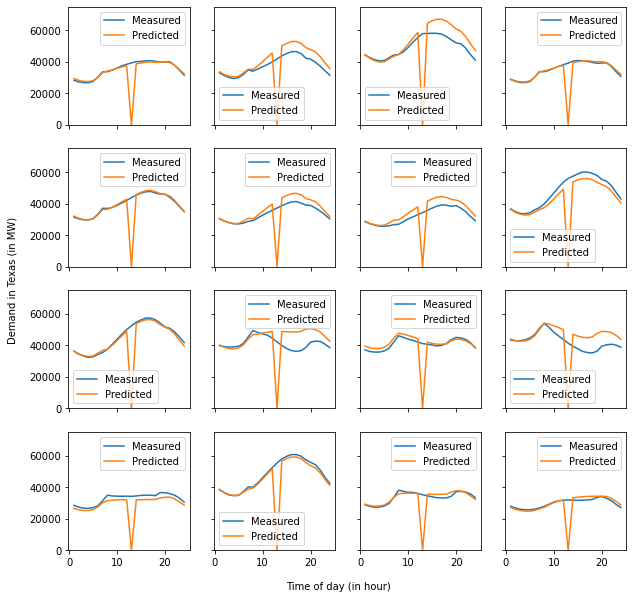

In [13]:
# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX) # insert code

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

**Question (10 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**The obtained final loss is affected by the number of epochs inversely. With more epochs, accuracy improves as the predicted line is very close to the measured line. Similarly, more epochs takes more time to train. Having tested 10, 100, 1000, 5000, 10000 epochs, 1000 is my favorite because it takes a reasonable time to run and provides a decent loss. 5000 takes too much more time for a loss that isn't significantly proportionally lower.**

**Question (15 points).** Fix the number of epochs to your favorite one. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. 

**I observe there to be roughly similar speed but a huge increase in accuracy, as loss values were much much lower comparatively.**

**Your answer (comments here, code below). Your code should show the results for the case with an additional hidden layer. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons**

In [94]:
nHidden1 = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX1 = np.shape(trainX)[1]
nDimY1 = np.shape(trainY)[1]

# Construct the neural network using relu
inputs1 = keras.layers.Input(nDimX1) #insert code
nn_layers = keras.layers.Dense(nHidden, activation="relu", name="dense_1")(inputs1) #insert code
nn_layers1 = keras.layers.Dense(nHidden, activation="relu", name="dense_2")(nn_layers) #insert code
outputs1 = keras.layers.Dense(nDimY, activation="relu")(nn_layers1)#insert code

model1 = keras.Model(inputs=inputs1, outputs=outputs1)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model1.compile(
    optimizer= tf.optimizers.Adagrad(learning_rate=0.5),#insert code
    loss= keras.losses.MeanSquaredError()#insert code 
)

batchSize1 = 10#
nEpochs1 = 1000#

# Train the model

print("Fit model on training data")

history = model1.fit(
    # insert code
    trainX,
    trainY,
    batch_size=batchSize1,
    epochs=nEpochs1
)


Fit model on training data
Epoch 1/1000
29/29 [==============================] - 0s 1ms/step - loss: 2282642688.0000
Epoch 2/1000
29/29 [==============================] - 0s 1ms/step - loss: 341246880.0000
Epoch 3/1000
29/29 [==============================] - 0s 1ms/step - loss: 291406240.0000
Epoch 4/1000
29/29 [==============================] - 0s 981us/step - loss: 265272480.0000
Epoch 5/1000
29/29 [==============================] - 0s 960us/step - loss: 253696496.0000
Epoch 6/1000
29/29 [==============================] - 0s 986us/step - loss: 247766160.0000
Epoch 7/1000
29/29 [==============================] - 0s 962us/step - loss: 244275440.0000
Epoch 8/1000
29/29 [==============================] - 0s 958us/step - loss: 236467120.0000
Epoch 9/1000
29/29 [==============================] - 0s 931us/step - loss: 233392736.0000
Epoch 10/1000
29/29 [==============================] - 0s 957us/step - loss: 231402336.0000
Epoch 11/1000
29/29 [==============================] - 0s 919us/ste

29/29 [==============================] - 0s 871us/step - loss: 4493968.5000
Epoch 182/1000
29/29 [==============================] - 0s 868us/step - loss: 4377058.5000
Epoch 183/1000
29/29 [==============================] - 0s 867us/step - loss: 4343882.5000
Epoch 184/1000
29/29 [==============================] - 0s 864us/step - loss: 4352195.0000
Epoch 185/1000
29/29 [==============================] - 0s 880us/step - loss: 4293924.0000
Epoch 186/1000
29/29 [==============================] - 0s 878us/step - loss: 4346019.5000
Epoch 187/1000
29/29 [==============================] - 0s 862us/step - loss: 4409920.5000
Epoch 188/1000
29/29 [==============================] - 0s 936us/step - loss: 4454415.5000
Epoch 189/1000
29/29 [==============================] - 0s 925us/step - loss: 4768348.0000
Epoch 190/1000
29/29 [==============================] - 0s 919us/step - loss: 4276859.5000
Epoch 191/1000
29/29 [==============================] - 0s 914us/step - loss: 4072776.5000
Epoch 192/1000

29/29 [==============================] - 0s 1ms/step - loss: 3305321.2500
Epoch 362/1000
29/29 [==============================] - 0s 1ms/step - loss: 3425020.7500
Epoch 363/1000
29/29 [==============================] - 0s 983us/step - loss: 3361889.0000
Epoch 364/1000
29/29 [==============================] - 0s 906us/step - loss: 3379958.5000
Epoch 365/1000
29/29 [==============================] - 0s 913us/step - loss: 3343445.7500
Epoch 366/1000
29/29 [==============================] - 0s 897us/step - loss: 3344993.5000
Epoch 367/1000
29/29 [==============================] - 0s 858us/step - loss: 3248944.7500
Epoch 368/1000
29/29 [==============================] - 0s 858us/step - loss: 3530489.5000
Epoch 369/1000
29/29 [==============================] - 0s 877us/step - loss: 3536325.7500
Epoch 370/1000
29/29 [==============================] - 0s 867us/step - loss: 3345660.7500
Epoch 371/1000
29/29 [==============================] - 0s 875us/step - loss: 3235188.0000
Epoch 372/1000
29/

29/29 [==============================] - 0s 871us/step - loss: 2768123.0000
Epoch 542/1000
29/29 [==============================] - 0s 879us/step - loss: 2968974.7500
Epoch 543/1000
29/29 [==============================] - 0s 881us/step - loss: 2742938.0000
Epoch 544/1000
29/29 [==============================] - 0s 962us/step - loss: 2886650.5000
Epoch 545/1000
29/29 [==============================] - 0s 1ms/step - loss: 2822299.7500
Epoch 546/1000
29/29 [==============================] - 0s 1ms/step - loss: 2775524.7500
Epoch 547/1000
29/29 [==============================] - 0s 1ms/step - loss: 2737876.5000
Epoch 548/1000
29/29 [==============================] - 0s 989us/step - loss: 2798073.5000
Epoch 549/1000
29/29 [==============================] - 0s 995us/step - loss: 2761224.5000
Epoch 550/1000
29/29 [==============================] - 0s 957us/step - loss: 2664349.7500
Epoch 551/1000
29/29 [==============================] - 0s 978us/step - loss: 2944493.2500
Epoch 552/1000
29/29

29/29 [==============================] - 0s 937us/step - loss: 2385056.7500
Epoch 722/1000
29/29 [==============================] - 0s 974us/step - loss: 2426441.5000
Epoch 723/1000
29/29 [==============================] - 0s 1ms/step - loss: 2324656.2500
Epoch 724/1000
29/29 [==============================] - 0s 952us/step - loss: 2357059.2500
Epoch 725/1000
29/29 [==============================] - 0s 950us/step - loss: 2397325.7500
Epoch 726/1000
29/29 [==============================] - 0s 935us/step - loss: 2473739.7500
Epoch 727/1000
29/29 [==============================] - 0s 944us/step - loss: 2429351.5000
Epoch 728/1000
29/29 [==============================] - 0s 959us/step - loss: 2495457.0000
Epoch 729/1000
29/29 [==============================] - 0s 939us/step - loss: 2494586.7500
Epoch 730/1000
29/29 [==============================] - 0s 912us/step - loss: 2570275.7500
Epoch 731/1000
29/29 [==============================] - 0s 913us/step - loss: 2466307.5000
Epoch 732/1000
2

29/29 [==============================] - 0s 885us/step - loss: 2123106.2500
Epoch 902/1000
29/29 [==============================] - 0s 869us/step - loss: 2186044.7500
Epoch 903/1000
29/29 [==============================] - 0s 866us/step - loss: 2296733.0000
Epoch 904/1000
29/29 [==============================] - 0s 858us/step - loss: 2156882.5000
Epoch 905/1000
29/29 [==============================] - 0s 869us/step - loss: 2214814.2500
Epoch 906/1000
29/29 [==============================] - 0s 863us/step - loss: 2153469.2500
Epoch 907/1000
29/29 [==============================] - 0s 857us/step - loss: 2200364.0000
Epoch 908/1000
29/29 [==============================] - 0s 867us/step - loss: 2190239.0000
Epoch 909/1000
29/29 [==============================] - 0s 865us/step - loss: 2198584.0000
Epoch 910/1000
29/29 [==============================] - 0s 873us/step - loss: 2168478.2500
Epoch 911/1000
29/29 [==============================] - 0s 868us/step - loss: 2199374.0000
Epoch 912/1000

### The effect of wind energy (bonus).

In [109]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
...,...,...,...,...,...,...,...,...,...
8755,12/31/15 19:00,31-Dec,39909,3825,16170,9.6,23.7,484.0,14.5
8756,12/31/15 20:00,31-Dec,38737,4626,16170,11.9,28.6,801.0,20.9
8757,12/31/15 21:00,31-Dec,37588,4958,16170,13.2,30.7,332.0,7.2
8758,12/31/15 22:00,31-Dec,36356,4699,16170,12.9,29.1,-259.0,-5.2


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why?

**The code below repeats the whole process and applies the neural network on a new column at the end called net, MW. We can clearly see that wind energy causes the forecast (prediction) to be far higher than what is actually measured as the orange line is far higher than the blue line. This drastically decreases the accuracy of the predictions because the predictions are made without knowledge of how much alternative (wind) energy will be available. As it is there, less ERCOT load is needed.**

In [116]:
#dfDemand[dfDemand.columns[2]] = dfDemand[dfDemand.columns[2]] - dfDemand[dfDemand.columns[4]]
dfDemand['net, MW'] =  dfDemand['ERCOT Load, MW'] - dfDemand['Total Wind Installed, MW']
dfDemand

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change,"net, MW"
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN,27202
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9,26404
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6,25830
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5,25604
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8,25662
...,...,...,...,...,...,...,...,...,...,...
8755,12/31/15 19:00,31-Dec,39909,3825,16170,9.6,23.7,484.0,14.5,23739
8756,12/31/15 20:00,31-Dec,38737,4626,16170,11.9,28.6,801.0,20.9,22567
8757,12/31/15 21:00,31-Dec,37588,4958,16170,13.2,30.7,332.0,7.2,21418
8758,12/31/15 22:00,31-Dec,36356,4699,16170,12.9,29.1,-259.0,-5.2,20186


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.
Fit model on training data
Epoch 1/1000
29/29 [==============================] - 0s 1ms/step - loss: 246081584.0000
Epoch 2/1000
29/29 [==============================] - 0s 1ms/step - loss: 66217856.0000
Epoch 3/1000
29/29 [==============================] - 0s 1ms/step - loss: 38616148.0000
Epoch 4/1000
29/29 [==============================] - 0s 1ms/step - loss: 34822168.0000
Epoch 5/1000
29/29 [==============================] - 0s 1ms/step - loss: 33646616.0000
Epoch 6/1000
29/29 [==============================] - 0s 1ms/step - loss: 26444066.0000
Epoch 7/1000
29/29 [==============================] - 0s 1ms/step - loss: 24201288.0000
Epoch 8/1000
29/29 [==============================] - 0s 986us/step - loss: 23388182.0000
Epoch 9/1000
29/29 [==============================] - 0s 952us/step - loss: 21598758.0000
Epoch 10/1000
29/29 [==============================] - 0s 970us/

29/29 [==============================] - 0s 867us/step - loss: 2621982.0000
Epoch 181/1000
29/29 [==============================] - 0s 861us/step - loss: 2602429.7500
Epoch 182/1000
29/29 [==============================] - 0s 851us/step - loss: 2550302.7500
Epoch 183/1000
29/29 [==============================] - 0s 854us/step - loss: 2591066.7500
Epoch 184/1000
29/29 [==============================] - 0s 862us/step - loss: 2697980.0000
Epoch 185/1000
29/29 [==============================] - 0s 857us/step - loss: 2481253.0000
Epoch 186/1000
29/29 [==============================] - 0s 861us/step - loss: 2466607.0000
Epoch 187/1000
29/29 [==============================] - 0s 867us/step - loss: 2371901.7500
Epoch 188/1000
29/29 [==============================] - 0s 880us/step - loss: 2410224.0000
Epoch 189/1000
29/29 [==============================] - 0s 858us/step - loss: 2759777.5000
Epoch 190/1000
29/29 [==============================] - 0s 859us/step - loss: 2445989.5000
Epoch 191/1000

29/29 [==============================] - 0s 874us/step - loss: 1435751.7500
Epoch 361/1000
29/29 [==============================] - 0s 906us/step - loss: 1567173.8750
Epoch 362/1000
29/29 [==============================] - 0s 912us/step - loss: 1460362.6250
Epoch 363/1000
29/29 [==============================] - 0s 906us/step - loss: 1352280.0000
Epoch 364/1000
29/29 [==============================] - 0s 916us/step - loss: 1291793.2500
Epoch 365/1000
29/29 [==============================] - 0s 918us/step - loss: 1374483.3750
Epoch 366/1000
29/29 [==============================] - 0s 904us/step - loss: 1469192.2500
Epoch 367/1000
29/29 [==============================] - 0s 889us/step - loss: 1526462.5000
Epoch 368/1000
29/29 [==============================] - 0s 868us/step - loss: 1315324.7500
Epoch 369/1000
29/29 [==============================] - 0s 849us/step - loss: 1514018.2500
Epoch 370/1000
29/29 [==============================] - 0s 859us/step - loss: 1335569.6250
Epoch 371/1000

29/29 [==============================] - 0s 868us/step - loss: 849798.3750
Epoch 541/1000
29/29 [==============================] - 0s 853us/step - loss: 898587.1250
Epoch 542/1000
29/29 [==============================] - 0s 855us/step - loss: 940330.9375
Epoch 543/1000
29/29 [==============================] - 0s 872us/step - loss: 909885.1250
Epoch 544/1000
29/29 [==============================] - 0s 859us/step - loss: 890201.1875
Epoch 545/1000
29/29 [==============================] - 0s 876us/step - loss: 904487.5000
Epoch 546/1000
29/29 [==============================] - 0s 853us/step - loss: 895817.8125
Epoch 547/1000
29/29 [==============================] - 0s 856us/step - loss: 1030042.9375
Epoch 548/1000
29/29 [==============================] - 0s 860us/step - loss: 992820.5625
Epoch 549/1000
29/29 [==============================] - 0s 855us/step - loss: 837231.7500
Epoch 550/1000
29/29 [==============================] - 0s 858us/step - loss: 867076.0000
Epoch 551/1000
29/29 [==

29/29 [==============================] - 0s 857us/step - loss: 656878.2500
Epoch 723/1000
29/29 [==============================] - 0s 864us/step - loss: 596811.4375
Epoch 724/1000
29/29 [==============================] - 0s 858us/step - loss: 634145.8750
Epoch 725/1000
29/29 [==============================] - 0s 856us/step - loss: 623668.0000
Epoch 726/1000
29/29 [==============================] - 0s 852us/step - loss: 647177.2500
Epoch 727/1000
29/29 [==============================] - 0s 859us/step - loss: 615798.8125
Epoch 728/1000
29/29 [==============================] - 0s 851us/step - loss: 640829.8750
Epoch 729/1000
29/29 [==============================] - 0s 862us/step - loss: 671330.1250
Epoch 730/1000
29/29 [==============================] - 0s 859us/step - loss: 626384.5000
Epoch 731/1000
29/29 [==============================] - 0s 864us/step - loss: 611161.4375
Epoch 732/1000
29/29 [==============================] - 0s 862us/step - loss: 654274.0625
Epoch 733/1000
29/29 [===

29/29 [==============================] - 0s 876us/step - loss: 524040.7812
Epoch 905/1000
29/29 [==============================] - 0s 865us/step - loss: 529367.8125
Epoch 906/1000
29/29 [==============================] - 0s 866us/step - loss: 508652.6875
Epoch 907/1000
29/29 [==============================] - 0s 864us/step - loss: 507730.9062
Epoch 908/1000
29/29 [==============================] - 0s 860us/step - loss: 527734.1250
Epoch 909/1000
29/29 [==============================] - 0s 866us/step - loss: 623029.4375
Epoch 910/1000
29/29 [==============================] - 0s 893us/step - loss: 490857.4062
Epoch 911/1000
29/29 [==============================] - 0s 875us/step - loss: 460366.8750
Epoch 912/1000
29/29 [==============================] - 0s 881us/step - loss: 488842.8125
Epoch 913/1000
29/29 [==============================] - 0s 889us/step - loss: 462268.0625
Epoch 914/1000
29/29 [==============================] - 0s 857us/step - loss: 514588.0938
Epoch 915/1000
29/29 [===

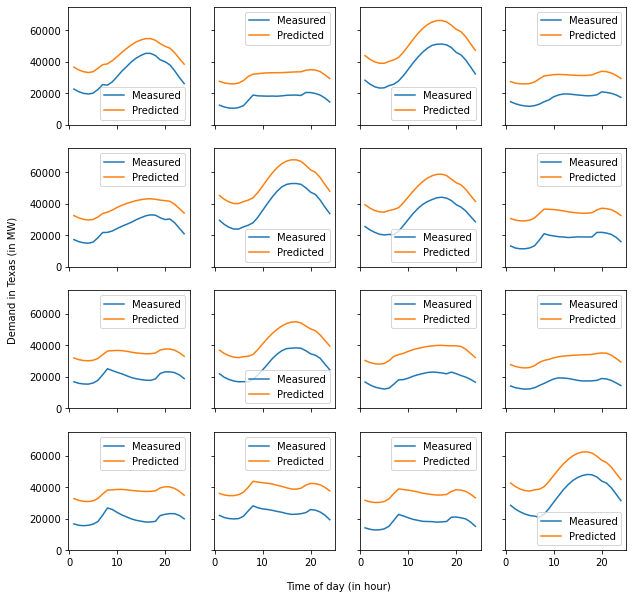

In [117]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'net, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'net, MW'].values.flatten() for day in rangeOfDays]

X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))

nHidden1 = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX1 = np.shape(trainX)[1]
nDimY1 = np.shape(trainY)[1]

# Construct the neural network using relu
inputs1 = keras.layers.Input(nDimX1) #insert code
nn_layers = keras.layers.Dense(nHidden, activation="relu", name="dense_1")(inputs1) #insert code
nn_layers1 = keras.layers.Dense(nHidden, activation="relu", name="dense_2")(nn_layers) #insert code
outputs1 = keras.layers.Dense(nDimY, activation="relu")(nn_layers1)#insert code

model1 = keras.Model(inputs=inputs1, outputs=outputs1)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model1.compile(
    optimizer= tf.optimizers.Adagrad(learning_rate=0.5),#insert code
    loss= keras.losses.MeanSquaredError()#insert code 
)

batchSize1 = 10#
nEpochs1 = 1000#

# Train the model

print("Fit model on training data")

history = model1.fit(
    # insert code
    trainX,
    trainY,
    batch_size=batchSize1,
    epochs=nEpochs1
)

# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX) # insert code

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()